# ДЗ 13. Outlier Detection
## Based on dataset of your choice test metric (accuracy / MSE) for training:
- Without filtering-out outliers
- With filtering-out outliers

## References:
- https://www.kaggle.com/datasets/vikrishnan/boston-house-prices
- https://machinelearningmastery.com/model-based-outlier-detection-and-removal-in-python/

#### Для выполнения ДЗ 13 выполним необходимые импорты модулей.

In [62]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

**Описание содержания табличного датасета**

Each record in the database describes a Boston suburb or town. The data was drawn from the Boston Standard Metropolitan Statistical Area (SMSA) in 1970. The attributes are deﬁned as follows (taken from the UCI Machine Learning Repository1:
- CRIM: per capita crime rate by town
- ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS: proportion of non-retail business acres per town
- CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- NOX: nitric oxides concentration (parts per 10 million)
1https://archive.ics.uci.edu/ml/datasets/Housing
123
20.2. Load the Dataset 124
- RM: average number of rooms per dwelling
- AGE: proportion of owner-occupied units built prior to 1940
- DIS: weighted distances to ﬁve Boston employment centers
- RAD: index of accessibility to radial highways
- TAX: full-value property-tax rate per 10000 dollars
- PTRATIO: pupil-teacher ratio by town 12. B: 1000(Bk−0.63)2 where Bk is the proportion of blacks by town 13.
- LSTAT: % lower status of the population
- MEDV: Median value of owner-occupied homes in $1000s

We can see that the input attributes have a mixture of units.


#### Считываем табличный датасет с данными, присваиваем заголовки

In [63]:
column_names = [
    'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE',
    'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV'
]

df = pd.read_csv('housing.csv', header=None, delimiter=r"\s+", names=column_names)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


#### Вывод информации о датасете для проверки датасета на содержание значений Null

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


#### Как можно наблюдать, все значения числовые, пропущенных значений нет.
#### Также выполним разделение обучения/тестирования и выполним масштабирование с помощью класса StandartScaler.


In [65]:
X = df.drop('MEDV', axis=1)
y = df['MEDV']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

std_s = StandardScaler()
X_train_scaled = std_s.fit_transform(X_train)
X_test_scaled = std_s.transform(X_test)
print(X_train_scaled.shape, y_train.shape)

(354, 13) (354,)


#### Так как мы не знаем есть ли аутлаеры в датасете, используем алгоритм линейной регрессии и оценим производительность модели, обучив модель на тестовом наборе данных и сделав прогноз на тестовых данных, и оценим прогнозы.
#### Для выполнения задания и получения сравнительной оценки между "сырым" набором данных и после удаления аутлаеров была выбрана метрика MSE (Mean Squared Error)

In [66]:
# evaluate model on the raw dataset

# fit the model
model = LinearRegression()

# model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# evaluate the model
yhat = model.predict(X_test_scaled)

# evaluate predictions
r_mse = mean_squared_error(y_test, yhat)
print(f'Raw dataset MSE: {r_mse:.3f}')

Raw dataset MSE: 19.831


#### По полученным результатам видно, что модель достигла значения MSE 19,831. Этот показатель будет отправной точной базового уровня производительности модели, с которым мы можем сравнивать различные методы определения и удаления выбросов.

#### Для наглядности, выполним графики на основе предсказанных и тестовых данных

In [67]:
def show_plt(y_test_, yhat_):
    temp = np.arange(0, len(y_test_))
    plt.scatter(temp, y_test_, color = 'red')
    plt.plot(temp, yhat_, color = 'blue')

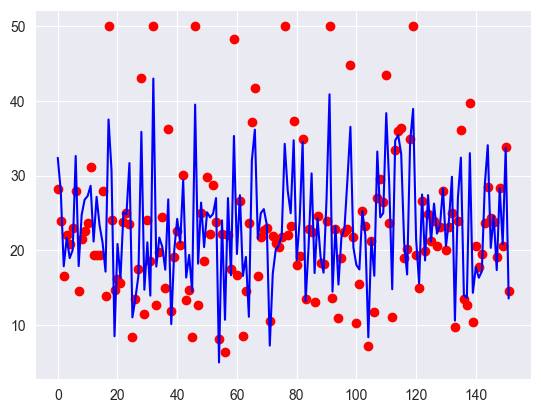

In [68]:
show_plt(y_test, yhat)

#### Применим метод определения аутлаеров iForest. Он основан на моделировании нормальных данных таким образом, чтобы изолировать аномалии, которые немногочисленны и различаются по пространству признаков. Число оценщиков примем = 200, количество образцов = 300.

In [69]:
# evaluate model performance with outliers removed using isolation forest
# # summarize the shape of the training dataset
print(f'{X_train.shape} {y_train.shape} [with outliers]')

# identify outliers in the training dataset
iso = IsolationForest(n_estimators=200, max_samples=300, contamination=0.1)
yhat = iso.fit_predict(X_train_scaled)

# select all rows that are not outliers
mask = yhat != -1
X_train_masked, y_train_masked = X_train_scaled[mask, :], y_train[mask]

# summarize the shape of the updated training dataset
print(f'{X_train_masked.shape} {y_train_masked.shape} [outliers removed]')

# fit the model
model = LinearRegression()
model.fit(X_train_masked, y_train_masked)

# evaluate the model
yhat = model.predict(X_test_scaled)

# evaluate predictions
mse = mean_squared_error(y_test, yhat)
print(f'{r_mse:.3f} [Raw dataset MSE]')
print(f'{mse:.3f} [iForest MSE]')

(354, 13) (354,) [with outliers]
(318, 13) (318,) [outliers removed]
19.831 [Raw dataset MSE]
18.851 [iForest MSE]


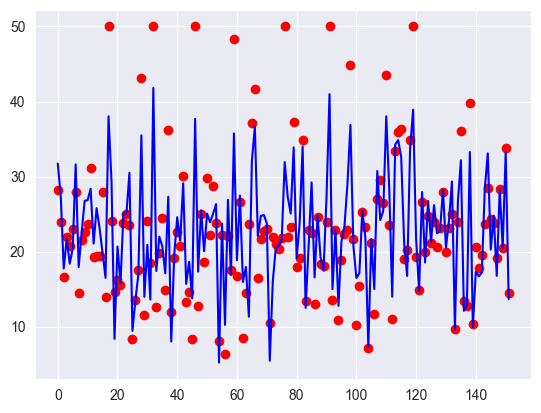

In [70]:
show_plt(y_test, yhat)

#### По полученным данным видно, что модель определила и удалила 38 аутлаеров, тем самым достилгла MSE 18,092. По сравнению с базовой моделью, которая достигла 19,831, этот результат является улучшением.

#### Применим метод определения аутлаеров Local outlier factor (LOF). Это более простой подход к выявлению выбросов и состоит в том, чтобы найти те образцы, которые далеки от других образцов в пространстве признаков.


In [71]:
# evaluate model performance with outliers removed using local outlier factor
# # summarize the shape of the training dataset
print(f'{X_train.shape} {y_train.shape} [with outliers]')

# identify outliers in the training dataset
lof = LocalOutlierFactor(n_neighbors=100)
yhat = lof.fit_predict(X_train)

# select all rows that are not outliers
mask = yhat != -1
X_train_masked, y_train_masked = X_train_scaled[mask, :], y_train[mask]

# summarize the shape of the updated training dataset
print(f'{X_train_masked.shape} {y_train_masked.shape} [outliers removed]')

# fit the model
model = LinearRegression()
model.fit(X_train_masked, y_train_masked)

# evaluate the model
yhat = model.predict(X_test_scaled)

# evaluate predictions
mse = mean_squared_error(y_test, yhat)
print(f'{r_mse:.3f} [Raw dataset MSE]')
print(f'{mse:.3f} [LOF]')

(354, 13) (354,) [with outliers]
(345, 13) (345,) [outliers removed]
19.831 [Raw dataset MSE]
19.819 [LOF]


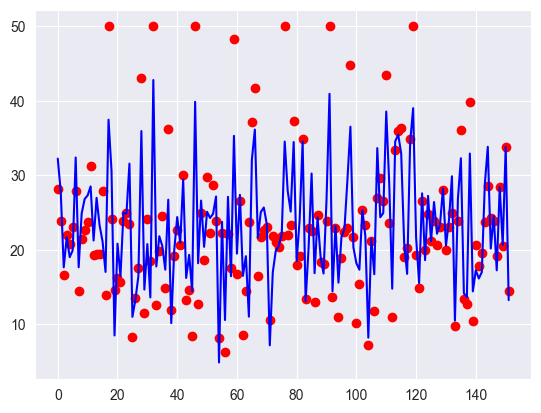

In [72]:
show_plt(y_test, yhat)

#### Как видно из полученных данных этот метод действительно хорошо работает с малым количеством признаков, модель определела и удалила 9 аутлаеров в датасете. Значение MSE достигло 19,819, что также в сравнении с базовой моделью будет результатом лучше, хотя уступает результату подели с импользованием метода  iForest.

#### Применим метод One-class SVM. Как мы знаем One-class SVM является алгоритмом классификации, но его можно использовать для обнаружения выбросов во входных данных как для наборов данных регрессии, так и для наборов данных классификации. Принимаем параметр верхней и нижней долей ошибок обучени nu=0.001.

In [73]:
# evaluate model performance with outliers removed using one class SVM
# summarize the shape of the training dataset
print(f'{X_train.shape} {y_train.shape} [with outliers]')

# identify outliers in the training dataset
ee = OneClassSVM(nu=0.001)
yhat = ee.fit_predict(X_train_scaled)

# select all rows that are not outliers
mask = yhat != -1
X_train_masked, y_train_masked = X_train_scaled[mask, :], y_train[mask]

# summarize the shape of the updated training dataset
print(f'{X_train_masked.shape} {y_train_masked.shape} [outliers removed]')

# fit the model
model = LinearRegression()
model.fit(X_train_masked, y_train_masked)

# evaluate the model
yhat = model.predict(X_test_scaled)

# evaluate predictions
mse = mean_squared_error(y_test, yhat)
print(f'{r_mse:.3f} [Raw dataset MSE]')
print(f'{mse:.3f} [One-class SVM]')

(354, 13) (354,) [with outliers]
(324, 13) (324,) [outliers removed]
19.831 [Raw dataset MSE]
19.439 [One-class SVM]


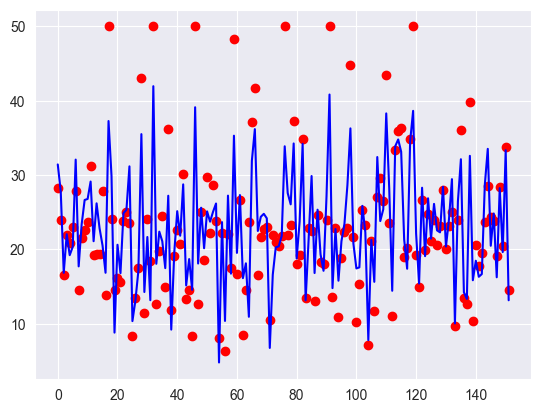

In [74]:
show_plt(y_test, yhat)

#### По полученным данным видно, что модель определила и удалила 30 аутлаеров. Значение MSE достигло 19,439, что также в сравнении с базовой моделью будет результатом лучше, хотя все также уступает результату подели с импользованием метода  iForest.

#### Как видно из проведенных экспериментов, влияние аутлаеров оказывают на качество модели большое значение даже на маленьком датасете, правильный подход к выбору метода выявления и удаления аутлаеров так же позволит сократить затраченное время и повысить результативность обучения моделей для прогнозного моделирования.
#### На графиках, примененных к каждой модели, изменения малоразличимы, интересной информации на небольшом датасете при построении графиков получить не удалось.